In [1]:
# データ準備
import numpy as npy
import matplotlib.pyplot as plt
%matplotlib inline
# アヤメ品種データの読み込み
from sklearn.datasets import load_iris

iris_data = load_iris()

# 説明変数
X_array = iris_data.data
# カラムデータを取得
X0=X_array[:,0]
X1=X_array[:,3]

# 目的変数
t_array = iris_data.target
T=t_array

N=len(X0)
petal_data=npy.zeros((N,2))
T3 = npy.zeros((N,3), dtype=npy.uint8)

#データの設定
for i in range(N):
    petal_data[i]=[X0[i], X1[i]]
    
    # 0[1,0,0]　1[0,1,0]　2[0,0,1]
    if T[i] == 0:
        T3[i]=[1,0,0]
    elif T[i] == 1:
        T3[i]=[0,1,0]
    else:
        T3[i]=[0,0,1]


X_range0=[min(X0)*0.9,max(X0)*1.1]
X_range1=[min(X1)*0.9,max(X1)*1.1]

# データをclassdata3.npzファイルに保存する
npy.savez('neural_rawdata.npz',X=petal_data,T3=T3,X_range0=X_range0,X_range1=X_range1,X_n=N)


In [2]:
# 生データファイルから取り出す
sample_data = npy.load('neural_rawdata.npz')
# 入力値の設定
X=sample_data['X']
# がく片の長さの表示範囲設定
X_range0=sample_data['X_range0']
# がく片の幅の表示範囲設定
X_range1=sample_data['X_range1']
# クラス（答え）の設定
T3=sample_data['T3']

# データの並び替え
X1 = X[:50,:]
X2 = X[50:100,:]
X3 = X[100:150,:]

npy.random.shuffle(X1)
npy.random.shuffle(X2)
npy.random.shuffle(X3)

X_test=npy.r_[X1[:25,:], X2[:25,:], X3[:25,:]]
X_train=npy.r_[X1[25:50,:],X2[25:50,:],X3[25:50,:]]
T_test=npy.r_[T3[:25,:], T3[50:75,:], T3[100:125,:]]
T_train=npy.r_[T3[25:50,:],T3[75:100,:],T3[125:150,:]]

npy.savez('neural_data.npz',X_train=X_train, T_train=T_train,X_test=X_test,T_test=T_test,X_range0=X_range0,X_range1=X_range1)


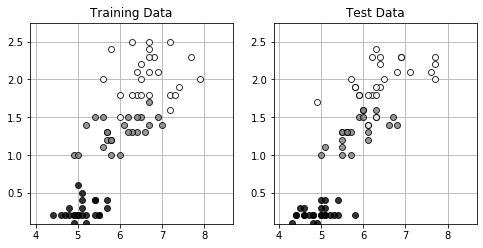

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# データの表示
def Show_data(x,t):
    wk,n=t.shape
    c=[[0,0,0],[.5,.5,.5],[1,1,1]]
    for i in range(n):
        plt.plot(x[t[:,i]==1,0],x[t[:,i]==1,1],linestyle='none',marker='o',markeredgecolor='black',color=c[i],alpha=0.8)
    plt.grid(True)

plt.figure(1,figsize=(8,3.7))
plt.subplot(1,2,1)
Show_data(X_train,T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')
plt.subplot(1,2,2)
Show_data(X_test,T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')

plt.show()


In [12]:
# シグモイド関数
def Sigmoid(x):
    y=1/(1+npy.exp(-x))
    return y

# ニューラルネットワーク（wv重み、M中間層ノード数、K出力層ノード数、x入力層の入力値）
def FNN(wv, M, K, x):
    # Nデータ数　Dデータの入力次元
    N, D = x.shape
    # w 入力層⇒中間層の重み
    w = wv[:M * (D+1)]
    w = w.reshape(M,(D+1))
    # v 中間層⇒出力層の重み
    v = wv[M*(D+1):]
    v = v.reshape((K,M+1))
    # b 中間層の入力総和
    b = npy.zeros((N,M+1))
    # z 中間層の出力値
    z = npy.zeros((N,M+1))
    # a 出力層の入力総和
    a = npy.zeros((N,K))
    # y 出力層の出力値
    y = npy.zeros((N,K))
    
    # データごとに中間層、出力層の計算を行う
    for n in range(N):
        # 中間層の計算（シグモイド関数）
        for m in range(M):
            b[n,m] = npy.dot(w[m,:],npy.r_[x[n,:],1])
            z[n,m] = Sigmoid(b[n,m])
        # ダミーニューロン
        z[n,M]=1
        u=0
        # 出力層の計算（）
        for k in range(K):
            a[n,k] = npy.dot(v[k,:],z[n,:])
            u = u + npy.exp(a[n,k])
        for k in range(K):
            y[n,k] = npy.exp(a[n,k])/u
    return y,a,z,b

# テスト実行
WV = npy.ones(15)
M = 2
K = 3
FNN(WV,M,K,X_train[:2,:])


(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.9955243 , 2.9955243 , 2.9955243 ],
        [2.99396317, 2.99396317, 2.99396317]]),
 array([[0.99776215, 0.99776215, 1.        ],
        [0.99698158, 0.99698158, 1.        ]]),
 array([[6.1, 6.1, 0. ],
        [5.8, 5.8, 0. ]]))

In [ ]:
# 平均誤差エントロピー誤差
def CE_FNN(wv,M,K,x,t):
    N,D = x.shape
    y,a,z,b=FNN(wv,M,K,x)
    ce = -npy.dot(t.reshape(-1),npy.log(y.reshape(-1))) / N
    return ce

# 微分式
def dCE_FNN_num(wv,M,K,x,t):
    epsilon = 0.001
    dwv = npy.zeros_like(wv)
    for iwv in range(len(wv)):
        wv_modified = wv.copy()
        wv_modified[iwv] = wv[iwv]-epsilon
        mse1 = CE_FNN(wv_modified,M,K,x,t)
        wv_modified[iwv] = wv[iwv]+epsilon
        mse2 = CE_FNN(wv_modified,M,K,x,t)
        dwv[iwv] = (mse2 - mse1)/(2*epsilon)
    return dwv

def Fit_FNN_num(wv_init,M,K,x_train,t_train,x_test,t_test,n,alpha):
    wv = wv_init
    err_train =npy.zeros(n)
    err_test = npy.zeros(n)
    wv_hist = npy.zeros((n,len(wv_init)))
    for i in range(n):
        wv = wv -alpha*dCE_FNN_num(wv,M,K,x_train,t_train)
        err_train[i] = CE_FNN(wv,M,K,x_train,t_train)
        err_test[i] = CE_FNN(wv,M,K,x_test,t_test)
        wv_hist[i,:]=wv
    return wv, wv_hist, err_train, err_test

M = 2
K = 3

npy.random.seed(1)
WV_init = npy.random.normal(0,0.01,M*3+K*(M+1))
N_step=1000
alpha=0.215

WV,WV_hist,Err_train,Err_test=Fit_FNN_num(WV_init,M,K,X_train,T_train,X_test,T_test,N_step,alpha)

# 学習誤差の表示
plt.figure(1,figsize=(3,3))
plt.plot(Err_train, 'black',label='training')
plt.plot(Err_test,'blue',label='test')
plt.legend()
plt.show()

plt.figure(1,figsize=(3,3))
plt.plot(WV_hist[:,:M*3], 'green')
plt.plot(WV_hist[:,M*3:],'orange')
plt.show()

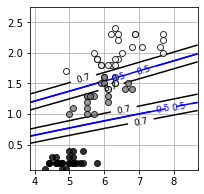

In [11]:
# 境界線の表示
def show_FNN(wv,M,K):
    xn = 60
    x0 = npy.linspace(X_range0[0],X_range0[1],xn)
    x1 = npy.linspace(X_range1[0],X_range1[1],xn)
    xx0, xx1 = npy.meshgrid(x0,x1)
    x = npy.c_[npy.reshape(xx0,xn*xn,1),npy.reshape(xx1,xn*xn,1)]
    y,a,z,b = FNN(wv,M,K,x)
    plt.figure(1,figsize=(4,4))
    for ic in range(K):
        f = y[:,ic]
        f = f.reshape(xn,xn)
        f = f.T
        cont = plt.contour(xx0,xx1,f,levels=[0.5,0.7],colors=['blue','black'])
        cont.clabel(fmt='%.1f',fontsize=9)
        plt.xlim(X_range0)
        plt.ylim(X_range1)

plt.figure(1,figsize=(3,3))
Show_data(X_test,T_test)
show_FNN(WV,M,K)
plt.show()